In [1]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [53]:
datadir = '../../../KDV/output/'
vkdvfiles = {
    'harmo_a0_data_rho':'{}/2021-09-09--08-16-36_slim-harmo_a0_data_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'harmo_a0_clim_rho':'{}/2021-09-09--08-15-46_slim-harmo_a0_clim_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'seasonal_a0_clim_rho':'{}/2021-09-09--08-17-24_slim-seasonal_a0_clim_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'seasonal_a0_data_rho':'{}/2021-09-09--08-18-10_slim-seasonal_a0_data_rho_v4_magnus_kdv_runs.nc'.format(datadir),   
}

names = ['harmo_a0_data_rho','harmo_a0_clim_rho','seasonal_a0_clim_rho','seasonal_a0_data_rho']
runtag = 'seasonal_a0_clim_rho'

In [54]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize':'large'})

In [55]:
def load_vkdv(vkdvfile):
    dskdv = xr.open_dataset(vkdvfile)
    idx = dskdv.time > np.datetime64('2030-01-01')
    ds = dskdv.isel({'time':~idx})
    return ds

In [56]:
ds = load_vkdv(vkdvfiles[runtag])

In [57]:
ds

<xarray.Dataset>
Dimensions:    (time: 362, ensemble: 500, params: 6)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-04 2016-05-05 ... 2017-04-30
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 ...
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 ...
    cn         (ensemble, time) float64 ...
    alpha      (ensemble, time) float64 ...
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 ...
    alpha_mu   (ensemble, time) float64 ...
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 ...
    usurf      (ensemble, time) float64 ...

In [58]:
alphavar = 'alpha_mu'
cvar = 'cn_mu'


# time
tmax = ds.tmax.values/(12.42*3600)
#tmax[tmax>3]=tmax[tmax>3]-1
tmax_min = tmax.min(axis=0)
tmax_max = tmax.max(axis=0)
tmax_50 = np.mean(tmax, axis=0)



T = 12.42*3600.
omega = 2*np.pi / T
Ls = ds.cn**2. / (np.abs(ds.alpha)*ds.a0*omega) 
Ls_mu = ds[cvar]**2. / (ds[alphavar]*ds.a0*omega) 

L = 1.05e5

c_nl = ds.cn + ds.amax*ds.alpha
c_nl_mu = ds[cvar] + ds.amax*ds[alphavar]

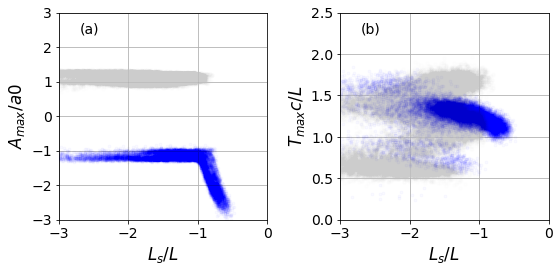

In [79]:
# Tnondim = tmax*T/(L*c_nl_mu)
# tlabel = r'$T_{max}/(c_{nl} L)$'

Tnondim = tmax*T*ds[cvar]/(L)
tlabel = r'$T_{max} c/L$'

idx = ds.amax.values.ravel()<0

plt.figure(figsize=(8,4))
ax3 = plt.subplot(121, rasterized=True)
# plt.plot(Ls/L, ds.amax/ds.a0, '.', color='0.5', alpha=0.02)
plt.plot( (Ls_mu/L).values.ravel()[~idx], (ds.amax/ds.a0).values.ravel()[~idx], '.', color='0.8', alpha=0.02)
plt.plot( (Ls_mu/L).values.ravel()[idx], (ds.amax/ds.a0).values.ravel()[idx], '.', color='b', alpha=0.02)
# plt.plot(Lhat, Ahat_g,'r--')
plt.xlim(-3.0,0)
plt.xticks([-3, -2,-1,0])
plt.ylim(-3,3)
plt.grid(b=True)
plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')
plt.text(0.1,0.9,'(a)', transform=ax3.transAxes)



ax4 = plt.subplot(122, rasterized=True)
# plt.plot(Ls/L, tmax*T*ds[cvar]/L, '.', color='b', alpha=0.02)
plt.plot(Ls_mu.values.ravel()[~idx]/L, Tnondim.values.ravel()[~idx]-1.5, '.', color='0.8', alpha=0.02)
plt.plot(Ls_mu.values.ravel()[idx]/L, Tnondim.values.ravel()[idx]-1.5, '.', color='b', alpha=0.02)
# plt.plot(Lhat, That_g,'r--')
plt.xlim(-3,0)
plt.xticks([-3,-2,-1,0])
plt.ylim(0,2.5)
plt.grid(b=True)
plt.ylabel(tlabel)
plt.xlabel('$L_s / L$')
plt.text(0.1,0.9,'(b)', transform=ax4.transAxes)

# plt.legend((u'$A_{max} > 0$',u'$A_{max} <= 0$'))

plt.tight_layout()

plt.savefig('../FIGURES/kdv_Amax_vs_Ls_{}.png'.format(runtag),dpi=150)
plt.savefig('../FIGURES/kdv_Amax_vs_Ls_{}.pdf'.format(runtag),dpi=300)